In [1]:
#Import libraries for analysis and visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns

In [2]:
#Generate wrangle function
def wrangle(filepath):
    #read csv file and set index to ID
    df = pd.read_csv(filepath, low_memory=False)
    #drop unwanted  URL columns
    df.drop(columns=["Source","Source_II","Source_III","Source_IV","Source_V","Source_VI","Source_VII"], inplace=True)
    #drop insignificant columns with extremely high null values and high autocorrelation
    df.drop(columns=["Genomics_Metadata","Country_ISO3","City","Date_onset","Hospitalised (Y/N/NA)",
                     "Date_hospitalisation","Isolated (Y/N/NA)","Date_isolation",
                     "Outcome","Contact_comment","Contact_ID","Contact_location",
                     "Date_death","Travel_history_entry","Travel_history_start","ID", "Location", "Travel_history_location"], inplace=True)
    #drop rows contontaining https://www.publichealthontario.ca/-/media/Documents/M/2022/monkeypox-episummary.pdf?sc_lang=en"
    df.drop(df.index[df["Status"]=="https://www.publichealthontario.ca/-/media/Documents/M/2022/monkeypox-episummary.pdf?sc_lang=en"], inplace=True)
    #drop rows with extreme null values ie rows containing status == omit_error
    df.drop(df.index[df["Status"]=="omit_error"], inplace=True)
    #drop rows containing discarded cases of monkeypox
    df.drop(df.index[df["Status"]=="discarded"], inplace=True)
    df.drop(df.index[df["Gender"]=="2022-06-03"], inplace=True)
    #fill null values according to the mode of suspected  and confirmed cases
    df["Status"] = df["Status"].fillna("confirmed")
    df.loc[df["Status"]=="confirmed"] = df.loc[df["Status"]=="confirmed"].fillna({"Symptoms":df.Symptoms.mode()[0],
                                                                                 "Gender":df.Gender.mode()[0],
                                                                                 "Age":df.Age.mode()[0],
                                                                                 "Confirmation_method":df.Confirmation_method.mode()[0]})
    df.loc[df["Status"]=="suspected"] = df.loc[df["Status"]=="suspected"].fillna({"Symptoms":"rash, fever",
                                                                                 "Age":"0-39",
                                                                                 "Gender":"Female",
                                                                                 "Confirmation_method":df.Confirmation_method.mode()[0]})
    #fill null values for all other columns
    df["Travel_history (Y/N/NA)"] = df["Travel_history (Y/N/NA)"].fillna("Y")
    df["Country"] = df["Country"].fillna(df["Country"].mode()[0])
    df["Travel_history_country"] = df["Travel_history_country"].fillna(df["Travel_history_country"].mode()[0])
    df["Date_last_modified"] = df["Date_last_modified"].fillna(df["Date_last_modified"].mode()[0])
    df["Date_confirmation"] = df["Date_confirmation"].fillna(df["Date_confirmation"].mode()[0])
    df["Date_entry"] = df["Date_entry"].fillna(df["Date_entry"].mode()[0])
    #convert time series object to datetime
    df["Date_last_modified"] = pd.to_datetime(df["Date_last_modified"], format="%Y-%m-%d")
    df["Date_confirmation"] = pd.to_datetime(df["Date_confirmation"], format="%Y-%m-%d")
    df["Date_entry"] = pd.to_datetime(df["Date_entry"], format="%Y-%m-%d")


   #drop duplicate rows
    df.drop_duplicates(keep="first",inplace=True)


    return df

In [3]:
df = wrangle("Monkeypox_df.csv")

In [4]:
df.head()

,Status,Country,Age,Gender,Date_confirmation,Symptoms,Travel_history (Y/N/NA),Travel_history_country,Confirmation_method,Date_entry,Date_last_modified
0,confirmed,England,20-69,Male,2022-05-06,rash,Y,Nigeria,RT-PCR,2022-05-18,2022-05-18
1,confirmed,England,20-69,Male,2022-05-12,rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
2,confirmed,England,20-69,Male,2022-05-13,vesicular rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
3,confirmed,England,20-69,Male,2022-05-15,vesicular rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
6,confirmed,England,20-69,Male,2022-05-15,vesicular rash,Y,England,RT-PCR,2022-05-18,2022-05-18


In [5]:
df.shape

(2003, 11)

In [6]:
df.columns

Index(['Status', 'Country', 'Age', 'Gender', 'Date_confirmation', 'Symptoms',
       'Travel_history (Y/N/NA)', 'Travel_history_country',
       'Confirmation_method', 'Date_entry', 'Date_last_modified'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2003 entries, 0 to 54002
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Status                   2003 non-null   object        
 1   Country                  2003 non-null   object        
 2   Age                      2003 non-null   object        
 3   Gender                   2003 non-null   object        
 4   Date_confirmation        2003 non-null   datetime64[ns]
 5   Symptoms                 2003 non-null   object        
 6   Travel_history (Y/N/NA)  2003 non-null   object        
 7   Travel_history_country   2003 non-null   object        
 8   Confirmation_method      2003 non-null   object        
 9   Date_entry               2003 non-null   datetime64[ns]
 10  Date_last_modified       2003 non-null   datetime64[ns]
dtypes: datetime64[ns](3), object(8)
memory usage: 187.8+ KB


In [8]:
df["Status"].value_counts()

confirmed    1964
suspected      39
Name: Status, dtype: int64

In [9]:
#Generate profile report
Report = ProfileReport(df,
title="Pandas Profilling report",
plot={"histogram": {"bins": 8}})

In [10]:
Report.to_file("Monkeypoxdata2.html")

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

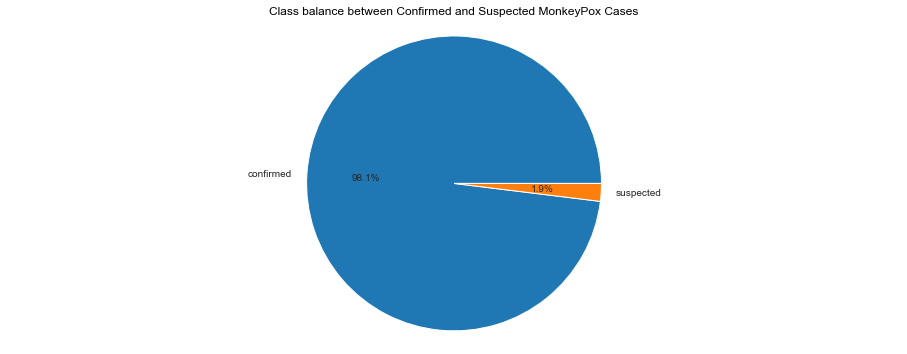

In [11]:
#check for class balance on target column
fig,ax = plt.subplots(figsize=(16,6))
sns.set_style('darkgrid')
labels = ['confirmed', 'suspected']
plt.pie(df["Status"].value_counts(), labels=labels, autopct='%1.1f%%')
plt.title("Class balance between Confirmed and Suspected MonkeyPox Cases")
plt.axis('equal');

In [12]:
#create mask based on confirmed cases
mask_conf = df.loc[df["Status"]=="confirmed"]
mask_conf

,Status,Country,Age,Gender,Date_confirmation,Symptoms,Travel_history (Y/N/NA),Travel_history_country,Confirmation_method,Date_entry,Date_last_modified
0,confirmed,England,20-69,Male,2022-05-06,rash,Y,Nigeria,RT-PCR,2022-05-18,2022-05-18
1,confirmed,England,20-69,Male,2022-05-12,rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
2,confirmed,England,20-69,Male,2022-05-13,vesicular rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
3,confirmed,England,20-69,Male,2022-05-15,vesicular rash,N,Spain,RT-PCR,2022-05-18,2022-05-18
6,confirmed,England,20-69,Male,2022-05-15,vesicular rash,Y,England,RT-PCR,2022-05-18,2022-05-18
...,...,...,...,...,...,...,...,...,...,...,...
53036,confirmed,Cameroon,20-69,Male,2022-07-17,genital ulcer lesions,Y,Spain,RT-PCR,2022-08-05,2022-08-05
53038,confirmed,Republic of Congo,20-69,Male,2022-07-31,genital ulcer lesions,Y,Spain,RT-PCR,2022-08-05,2022-08-12
53039,confirmed,Democratic Republic Of The Congo,20-69,Male,2022-07-28,genital ulcer lesions,Y,Spain,RT-PCR,2022-08-05,2022-08-05
53829,confirmed,Liberia,41-45,Male,2022-07-23,genital ulcer lesions,Y,Spain,RT-PCR,2022-08-05,2022-08-05


In [13]:
#groupby count of countries with confirmed cases
country_conf = (mask_conf.groupby("Status")["Country"]
                .value_counts(normalize=True)
                .sort_values()
                .rename("Frequency")
                .to_frame()
                .reset_index())

In [14]:
country_conf.tail(10)

,Status,Country,Frequency
93,confirmed,Portugal,0.022403
94,confirmed,Peru,0.024440
95,confirmed,Italy,0.025967
96,confirmed,Nigeria,0.029532
97,confirmed,Switzerland,0.030550
98,confirmed,Spain,0.042261
99,confirmed,Brazil,0.042770
100,confirmed,Canada,0.053462
101,confirmed,Germany,0.080957
102,confirmed,United States,0.147658


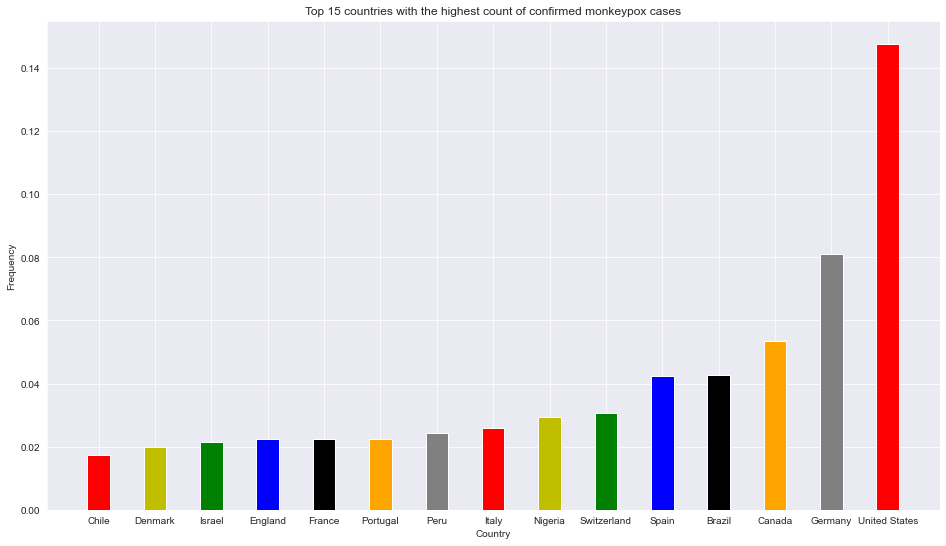

In [19]:
#plot top 15 countries with most number of confirmed monkeypox cases
fig, ax = plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
plt.bar(x='Country', height="Frequency",data=country_conf.tail(15),width=0.4, align='center', label="Country",
        color=['r','y','g','b','black','orange','grey'])
plt.title("Top 15 countries with the highest count of confirmed monkeypox cases")
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.show();

In [20]:
#visualize using plotly
fig = px.bar(data_frame=country_conf.tail(15),
            x="Country",
            y="Frequency",
            color="Country",
            title="Top 15 countries with the highest count of confirmed monkeypox cases")
fig.show()

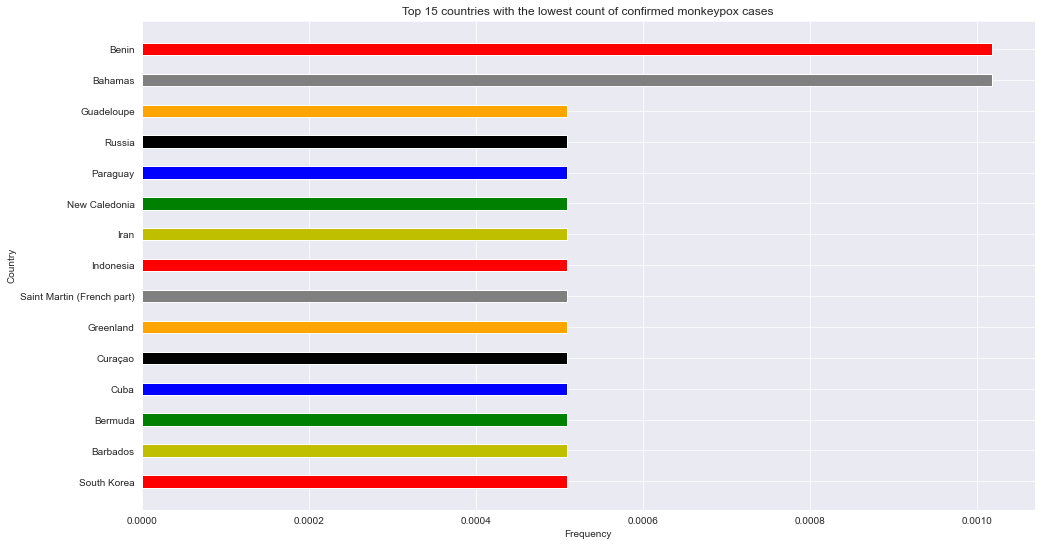

In [21]:
#plot top 15 countries with the lowest count of confirmed monkeypox cases
fig, ax = plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
plt.barh(y='Country',width="Frequency",data=country_conf.head(15),height=0.4, align='center', label="Country",
        color=['r','y','g','b','black','orange','grey'])
plt.xlabel("Frequency")
plt.ylabel("Country")
plt.title("Top 15 countries with the lowest count of confirmed monkeypox cases");

In [22]:
#visualize using plotly
fig = px.bar(data_frame=country_conf.head(15),
            x="Country",
            y="Frequency",
            color="Country",
            title="Top 15 countries with the lowest count of confirmed monkeypox cases")
fig.show()

In [23]:
#groupby country travel history with count of confirmed cases
travel_history_conf = (mask_conf.groupby("Status")["Travel_history_country"]
                       .value_counts(normalize=True)
                       .sort_values()
                       .rename("Frequency")
                       .to_frame()
                       .reset_index())

In [24]:
travel_history_conf.head(10)

,Status,Travel_history_country,Frequency
0,confirmed,Belgium,0.000509
1,confirmed,United Arab Emirates,0.000509
2,confirmed,Switzerland,0.000509
3,confirmed,Spain; Portugal,0.000509
4,confirmed,Spain; Germany,0.000509
5,confirmed,"Spain, Singapore",0.000509
6,confirmed,"Spain, Portugal",0.000509
7,confirmed,Netherlands and Spain,0.000509
8,confirmed,"Italy, Spain",0.000509
9,confirmed,Gran Canaria,0.000509


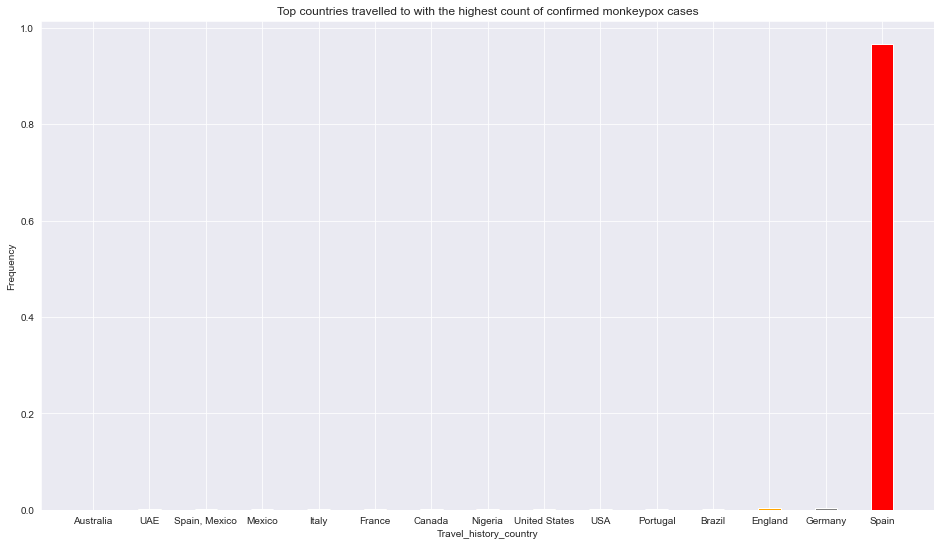

In [25]:
#plot top 15 most travelled countries with most number of confirmed monkeypox cases
fig, ax = plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
plt.bar(x='Travel_history_country', height="Frequency",data=travel_history_conf.tail(15),
        width=0.4, align='center', label="Country",
        color=['r','y','g','b','black','orange','grey'])
plt.title("Top countries travelled to with the highest count of confirmed monkeypox cases")
plt.xlabel("Travel_history_country")
plt.ylabel("Frequency");

In [26]:
fig = px.bar(data_frame=travel_history_conf.tail(15),
            x="Travel_history_country",
            y="Frequency",
            color="Travel_history_country",
            title="Top 15 countries travelled with the highest count of confirmed monkeypox cases")
fig.show()

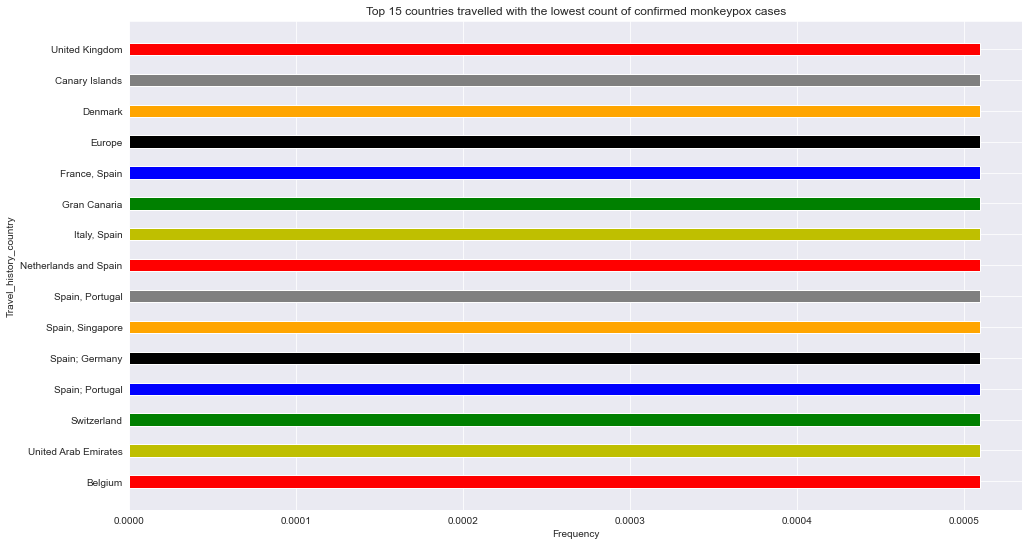

In [27]:
#plot top 15 countries with most number of confirmed monkeypox cases
fig, ax = plt.subplots(figsize=(16,9))
sns.set_style('darkgrid')
plt.barh(y='Travel_history_country', width="Frequency",data=travel_history_conf.head(15),
        height=0.4, align='center', label="Country",
        color=['r','y','g','b','black','orange','grey'])
plt.title("Top 15 countries travelled with the lowest count of confirmed monkeypox cases")
plt.xlabel("Frequency")
plt.ylabel("Travel_history_country");

In [28]:
fig = px.bar(data_frame=travel_history_conf.head(15),
            x="Travel_history_country",
            y="Frequency",
            color="Travel_history_country",
            title="Top 15 countries travelled with the lowest count of confirmed monkeypox cases")
fig.show()

In [29]:
#group countries with confirmed cases and countries travelled
country_travel_history_conf = (mask_conf.groupby("Country")["Travel_history_country"]
                               .value_counts(normalize=True)
                               .sort_values()
                               .rename("Frequency")
                               .to_frame()
                               .reset_index())

In [30]:
country_travel_history_conf.head()   

,Country,Travel_history_country,Frequency
0,United States,Mexico,0.003448
1,United States,United States,0.003448
2,United States,travel to a country experiencing MPX outbreak,0.003448
3,Germany,Europe,0.006289
4,Germany,Gran Canaria,0.006289


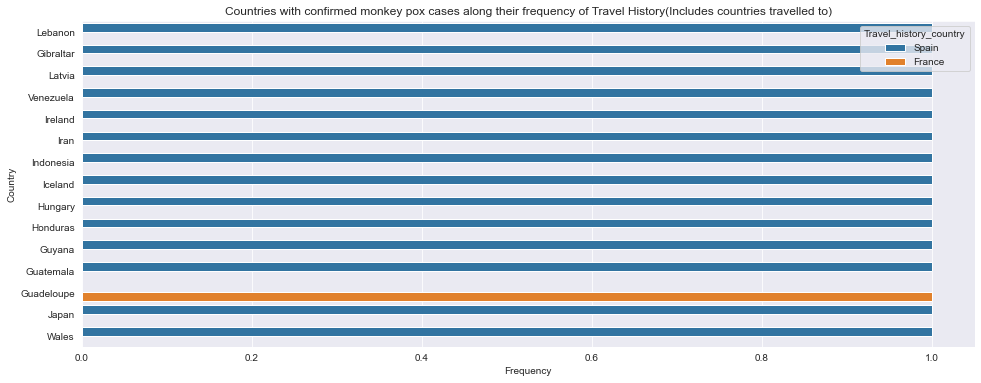

In [36]:
fig, ax = plt.subplots(figsize=(16,6))
sns.set_style('darkgrid')

sns.barplot(x="Frequency", y="Country", hue="Travel_history_country", data=country_travel_history_conf.tail(15), ax=ax)
plt.title("Countries with confirmed monkey pox cases along their frequency of Travel History(Includes countries travelled to)");

In [37]:
fig = px.bar(data_frame=country_travel_history_conf.tail(15),
            x="Country",
            y="Frequency",
            color="Travel_history_country",
            title="Countries with confirmed monkey pox cases along their frequency of Travel History(Includes countries travelled to)")
fig.show()

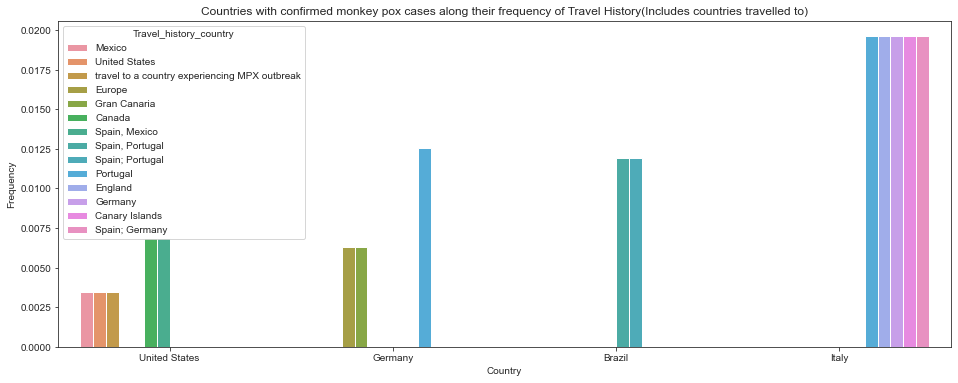

In [42]:
fig, ax = plt.subplots(figsize=(16,6))
sns.set_style("ticks")
sns.barplot(x="Country", y="Frequency", hue="Travel_history_country", data=country_travel_history_conf.head(15), ax=ax)
plt.title("Countries with confirmed monkey pox cases along their frequency of Travel History(Includes countries travelled to)");

In [43]:
fig = px.bar(data_frame=country_travel_history_conf.head(15),
            x="Country",
            y="Frequency",
            color="Travel_history_country",
             barmode="group",
            title="(Countries with confirmed monkey pox cases along their frequency ofTravel History(Includes countries travelled to)")
fig.show()

In [44]:
#Subset to only Status and date of confirmation
status_date_conf = (mask_conf.groupby("Status")["Date_confirmation"]
                    .value_counts()
                    .sort_values()
                    .rename("Frequency")
                    .to_frame()
                    .reset_index())

In [45]:
status_date_conf = status_date_conf.drop(columns="Status")

In [46]:
status_date_conf = status_date_conf.set_index("Date_confirmation")

In [47]:
status_date_conf.tail(20)

,Frequency
Date_confirmation,
2022-06-28,28
2022-06-21,29
2022-07-14,29
2022-07-29,29
2022-08-02,29
2022-08-05,29
2022-08-01,29
2022-07-13,30
2022-07-12,30


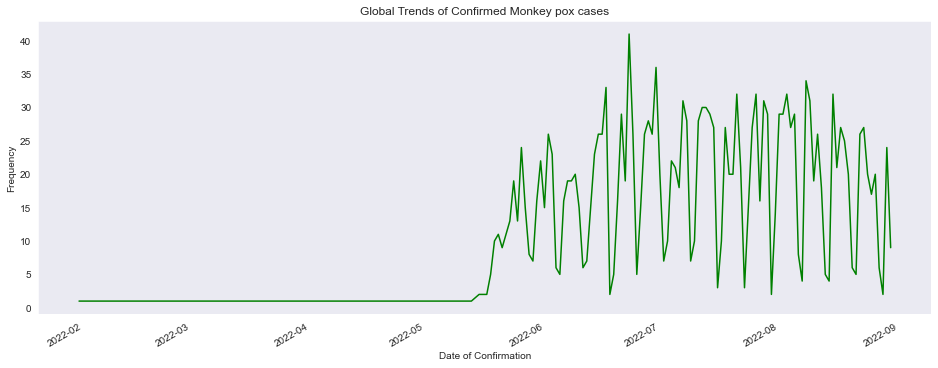

In [56]:
#Trends of confirmed reported cases
fig, ax = plt.subplots(figsize=(16,6))
sns.set_style("dark")
status_date_conf["Frequency"].plot(ax=ax, color="green")
plt.xlabel("Date of Confirmation")
plt.ylabel("Frequency")
plt.title("Global Trends of Confirmed Monkey pox cases")
plt.show();

In [57]:
#subset to Date of entry to get trends of cases based on entry after travel
status_date_entry = (mask_conf.groupby("Status")["Date_entry"]
                     .value_counts()
                     .sort_values()
                     .rename("Frequency")
                     .to_frame()
                     .reset_index())

In [58]:
status_date_entry = status_date_entry.drop(columns="Status").set_index("Date_entry")

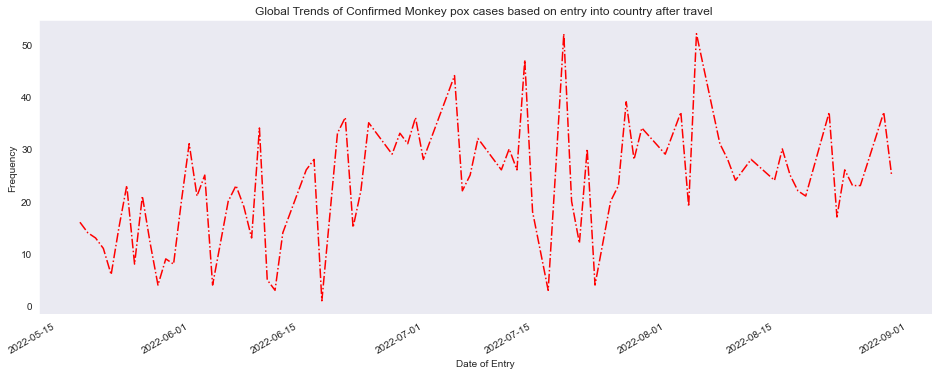

In [60]:
#Trends of confirmed reported cases
fig, ax = plt.subplots(figsize=(16,6))
sns.set_style("dark")
status_date_entry["Frequency"].plot(ax=ax, color=["red"], linestyle="-.")
plt.title("Global Trends of Confirmed Monkey pox cases based on entry into country after travel ")
plt.xlabel("Date of Entry")
plt.ylabel("Frequency");

In [61]:
#subset to date_last_modified to get trends of confirmed cases based on last modification of documented confirmed cases
last_modified_conf = (mask_conf.groupby("Status")["Date_last_modified"]
                      .value_counts()
                      .sort_values()
                      .rename("Frequency")
                      .to_frame()
                      .reset_index())

In [62]:
last_modified_conf = last_modified_conf.drop(columns="Status").set_index("Date_last_modified")

In [63]:
last_modified_conf.head()

,Frequency
Date_last_modified,
2022-07-04,1
2022-05-08,1
2022-06-04,1
2022-05-22,1
2022-05-19,2


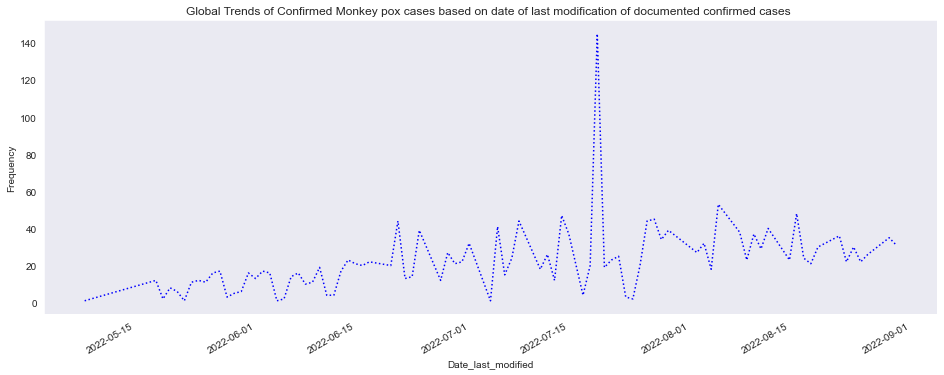

In [64]:
fig, ax = plt.subplots(figsize=(16,6))
sns.set_style("dark")
last_modified_conf["Frequency"].plot(ax=ax, color=["blue"], linestyle=":")
plt.title("Global Trends of Confirmed Monkey pox cases based on date of last modification of documented confirmed cases ")
plt.ylabel("Frequency");

In [65]:
#what are the prevalent symptoms of confirmed monkeypox cases
#get text variable for word cloud
text = " ".join(cat for cat in mask_conf.Symptoms)
#Generate word cloud
word_cloud = WordCloud(width=3000,
                      height=2000,
                      random_state=42,
                      background_color="Salmon",
                      colormap="winter_r",
                      collocations="False",
                      stopwords=STOPWORDS,).generate(text)

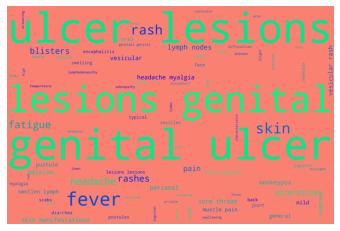

In [66]:
#Display image
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

Symptoms of Confirmed Monkeypox cases

In [67]:
#what are the prevalent confirmation method of confirmed monkeypox cases
#get text variable for word cloud
text = " ".join(cat for cat in mask_conf.Confirmation_method)
#Generate word cloud
word_cloud = WordCloud(width=3000,
                      height=2000,
                      random_state=42,
                      background_color="Salmon",
                      colormap="winter_r",
                      collocations="False",
                      stopwords=STOPWORDS,).generate(text)

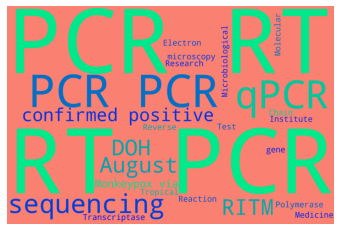

In [68]:
#Display image
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

Confirmation method of confirmed monkey pox cases

In [69]:
#How about the distribution of suspected cases?
#Create mask for only suspected cases
mask_susp = df.loc[df["Status"]=="suspected"]
mask_susp

,Status,Country,Age,Gender,Date_confirmation,Symptoms,Travel_history (Y/N/NA),Travel_history_country,Confirmation_method,Date_entry,Date_last_modified
401,suspected,Sudan,0-39,Female,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-05-26,2022-05-26
494,suspected,Iran,0-39,Female,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-05-27,2022-05-27
505,suspected,Pakistan,10-14,Male,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-05-29,2022-05-29
889,suspected,Canada,0-39,Female,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-06-01,2022-06-03
1107,suspected,Cayman Islands,0-39,Female,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-06-04,2022-06-04
1817,suspected,Uganda,0-5,Female,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-06-11,2022-06-11
1818,suspected,Uganda,10-14,Female,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-06-11,2022-06-11
1819,suspected,Uganda,0-39,Female,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-06-11,2022-06-11
4174,suspected,Somalia,0-39,Female,2022-08-22,"rash, fever",Y,Spain,RT-PCR,2022-06-24,2022-06-24
4176,suspected,Somalia,0-39,Female,2022-08-22,"rash, fever",Y,South Africa,RT-PCR,2022-06-24,2022-06-24


In [70]:
#groupby count of countries with suspected cases
country_susp = (mask_susp.groupby("Status")["Country"]
                .value_counts(normalize=True)
                .sort_values().rename("Frequency")
                .to_frame()
                .reset_index())

In [71]:
country_susp

,Status,Country,Frequency
0,suspected,Cayman Islands,0.025641
1,suspected,Central African Republic,0.025641
2,suspected,Costa Rica,0.025641
3,suspected,Ecuador,0.025641
4,suspected,Iran,0.025641
5,suspected,Pakistan,0.025641
6,suspected,Republic of Congo,0.025641
7,suspected,Sierra Leone,0.025641
8,suspected,Sudan,0.025641
9,suspected,Zambia,0.025641


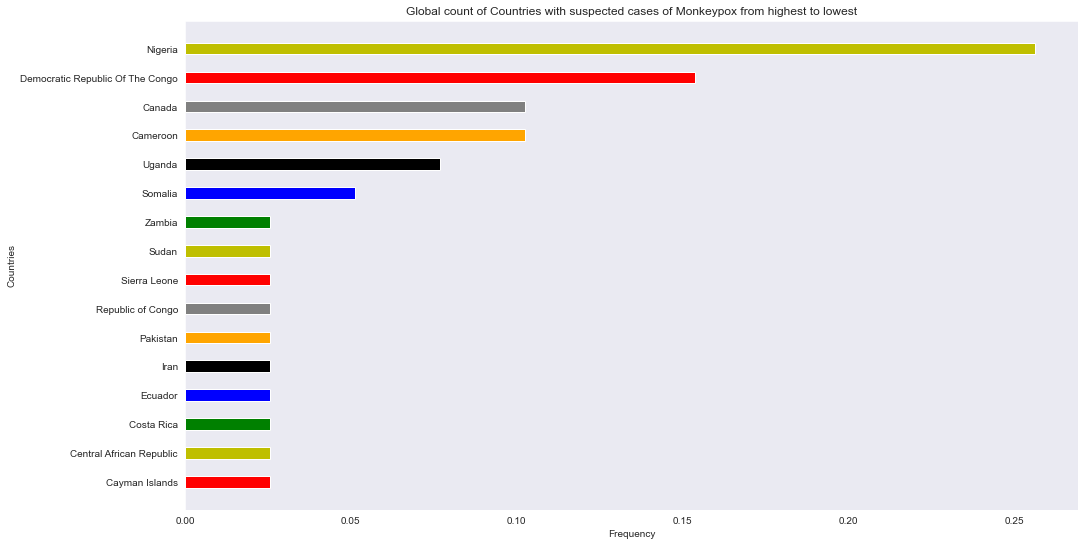

In [75]:
#plot top 15 countries with most number of confirmed monkeypox cases
fig, ax = plt.subplots(figsize=(16,9))
sns.set_style("dark")
plt.barh(y='Country', width="Frequency",data=country_susp,
        height=0.4, align='center', label="Country",
        color=['r','y','g','b','black','orange','grey'])
plt.xlabel("Frequency")
plt.ylabel("Countries")
plt.title("Global count of Countries with suspected cases of Monkeypox from highest to lowest");

In [76]:
#visualize using plotly
fig = px.bar(data_frame=country_susp,
            x="Country",
            y="Frequency",
            color="Country",
            title="Global count of Countries with suspected cases of Monkeypox from lowest to highest")
fig.show()

In [77]:
#groupby count of suspected cases based on country travelled to
travel_susp = (mask_susp.groupby("Status")["Travel_history_country"]
               .value_counts(normalize=True)
               .sort_values()
               .rename("Frequency")
               .to_frame()
               .reset_index())

In [78]:
travel_susp

,Status,Travel_history_country,Frequency
0,suspected,South Africa,0.025641
1,suspected,United States,0.025641
2,suspected,Spain,0.948718


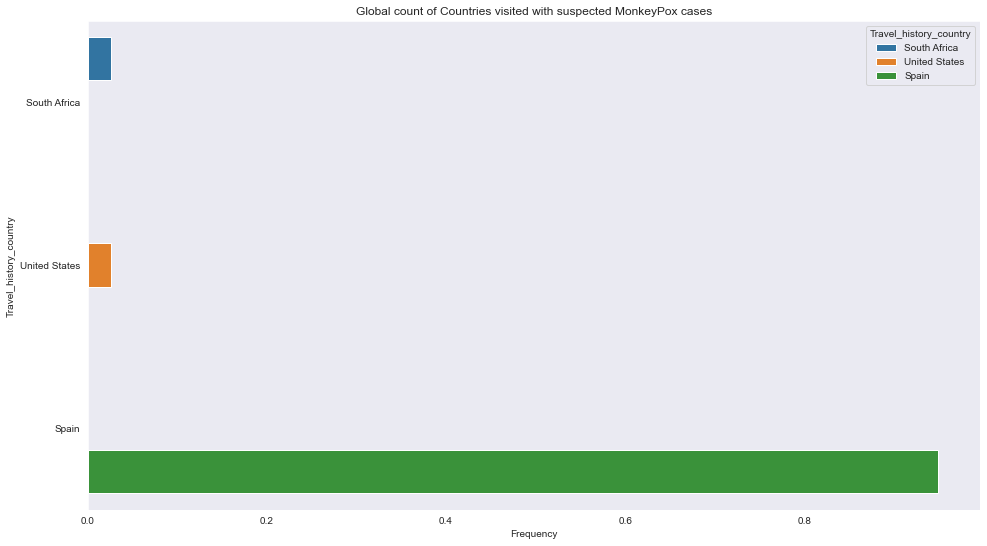

In [80]:
#plot top 15 countries with most number of confirmed monkeypox cases
fig, ax = plt.subplots(figsize=(16,9))
sns.set_style("dark")
sns.barplot(x="Frequency", y="Travel_history_country",hue="Travel_history_country", data=travel_susp, ax=ax)
plt.title("Global count of Countries visited with suspected MonkeyPox cases");

In [81]:
#visualize using plotly
fig = px.bar(data_frame=travel_susp,
            x="Travel_history_country",
            y="Frequency",
            color="Travel_history_country",
            title="Global count of Countries visited with suspected MonkeyPox cases")
fig.show()

In [82]:
#group countries with susupected cases and travel history
country_travel_history_conf = (mask_susp.groupby("Country")["Travel_history_country"].value_counts(normalize=True).sort_values()
                               .rename("Frequency")
                               .to_frame()
                               .reset_index())

In [83]:
country_travel_history_conf

,Country,Travel_history_country,Frequency
0,Somalia,Spain,0.5
1,Somalia,South Africa,0.5
2,Cameroon,Spain,1.0
3,Sudan,Spain,1.0
4,Sierra Leone,Spain,1.0
5,Republic of Congo,Spain,1.0
6,Pakistan,Spain,1.0
7,Uganda,Spain,1.0
8,Nigeria,Spain,1.0
9,Ecuador,Spain,1.0


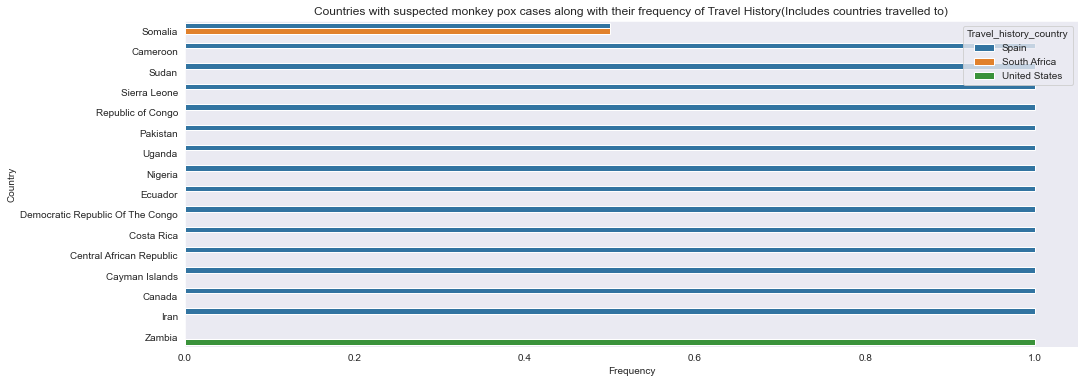

In [84]:
fig, ax = plt.subplots(figsize=(16,6))
sns.barplot(x="Frequency", y="Country", hue="Travel_history_country", data=country_travel_history_conf, ax=ax)
plt.title("Countries with suspected monkey pox cases along with their frequency of Travel History(Includes countries travelled to)");

In [85]:
fig = px.bar(data_frame=country_travel_history_conf,
            x="Country",
            y="Frequency",
            color="Travel_history_country",
             barmode="group",
            title="Visited Countries with suspected monkey pox cases")
fig.show()

In [86]:
#trends of suspected cases based on date of entry into country
date_entry_susp = (mask_susp.groupby("Status")["Date_entry"]
                   .value_counts()
                   .rename("Frequency")
                  .to_frame()
                  .reset_index())

In [87]:
date_entry_susp = date_entry_susp.drop(columns="Status").set_index("Date_entry")

In [88]:
date_entry_susp

,Frequency
Date_entry,
2022-06-01,4
2022-06-06,3
2022-06-11,3
2022-06-24,3
2022-06-07,2
2022-06-10,2
2022-06-20,2
2022-08-05,2
2022-08-12,2


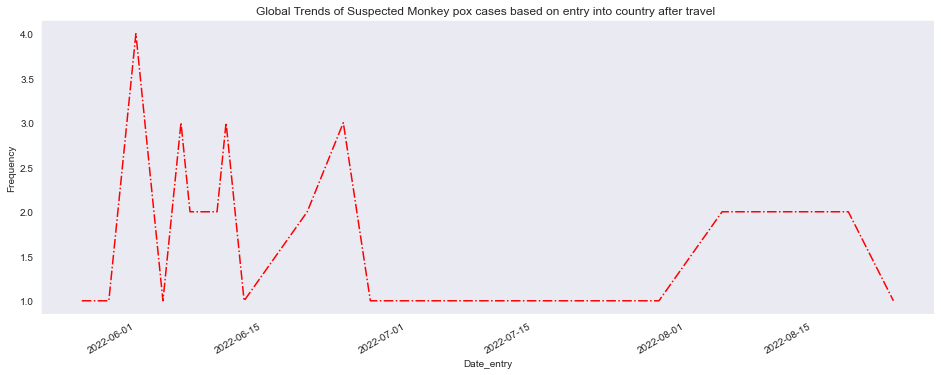

In [89]:
#Trends of suspected reported cases
fig, ax = plt.subplots(figsize=(16,6))
sns.set_style("dark")
date_entry_susp["Frequency"].plot(ax=ax, color=["red"], linestyle="-.")
plt.title("Global Trends of Suspected Monkey pox cases based on entry into country after travel ")
plt.ylabel("Frequency");

In [90]:
#what are the prevalent symptoms of suspected monkeypox cases
#get text variable for word cloud
text = " ".join(cat for cat in mask_susp.Symptoms)
#Generate word cloud
word_cloud = WordCloud(width=3000,
                      height=2000,
                      random_state=42,
                      background_color="Salmon",
                      colormap="winter_r",
                      collocations="False",
                      stopwords=STOPWORDS,).generate(text)

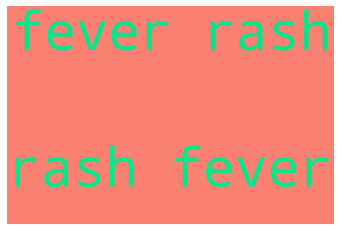

In [91]:
#Display image
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

Symptoms of Suspected Monkey pox cases

In [92]:
#What is the Predominant age range of confirmed and suspected cases?
#aggregate Age in relation to Status
df_age = ((df["Age"]
           .groupby(df["Status"]))
          .value_counts()
          .sort_values()
          .rename("Frequency")
         .to_frame()
         .reset_index())

In [93]:
df_age

,Status,Age,Frequency
0,suspected,20-24,1
1,confirmed,22-43,1
2,confirmed,20-62,1
3,confirmed,20-60,1
4,confirmed,20-50,1
...,...,...,...
81,suspected,0-39,35
82,confirmed,35-39,38
83,confirmed,25-29,39
84,confirmed,30-34,57


In [94]:
#visualize confirmed and suspected cases based on age range
fig = px.bar(
    data_frame=df_age,
    x="Age",
    y="Frequency",
    color="Status",
    barmode="group",
    title="Predominant Age Range of Confirmed and Suspected cases of Monkey Pox"
     )
fig.show()

In [95]:
#What is the Predominant gender of confirmed and suspected cases?
#aggregate Gender in relation to Status
df_gender = ((df["Gender"]
           .groupby(df["Status"]))
          .value_counts(normalize=True)
          .sort_values()
          .rename("Frequency")
         .to_frame()
         .reset_index())

In [96]:
df_gender

,Status,Gender,Frequency
0,confirmed,Female,0.007128
1,suspected,Male,0.025641
2,suspected,Female,0.974359
3,confirmed,Male,0.992872


In [97]:
#visualize confirmed and suspected cases based on gender
fig = px.bar(
    data_frame=df_gender,
    x="Gender",
    y="Frequency",
    color="Status",
    barmode="group",
    title="Confirmed and Suspected Monkey pox cases based on Gender"
     )
fig.show()

In [98]:
df_history = ((df["Travel_history (Y/N/NA)"]
           .groupby(df["Status"]))
          .value_counts(normalize=True)
          .sort_values()
          .rename("Frequency")
         .to_frame()
         .reset_index())

In [99]:
df_history

,Status,Travel_history (Y/N/NA),Frequency
0,confirmed,N,0.024949
1,confirmed,Y,0.975051
2,suspected,Y,1.000000


In [100]:
#visualize confirmed and suspected cases based on gender
fig = px.bar(
    data_frame=df_history,
    x="Travel_history (Y/N/NA)",
    y="Frequency",
    color="Status",
    barmode="group",
    title="Confirmed and Suspected Monkey pox cases based on individuals with Travel history and Without Travel History"
     )
fig.show()